# 🛒 Market Basket Analysis - Discovering Frequent Item Combinations in Grocery Data 🛒
Welcome, data enthusiasts! Your mission is to uncover frequent item combinations in supermarket purchases using association rule learning. We will follow these steps:
- Preprocess data (convert transaction lists into a matrix format)
- the Apriori algorithm to find strong association rules (e.g., "People who buy milk often buy bread")
- Visualize the results using network graphs

#### What is Market Basket Analysis?
Market basket analysis is a technique for identifying relationships between items in large datasets of customer transactions. It is a valuable tool for data mining and machine learning, and is widely used in retail and e-commerce to identify which items are frequently purchased together in a transaction, with the goal of improving sales and customer loyalty.

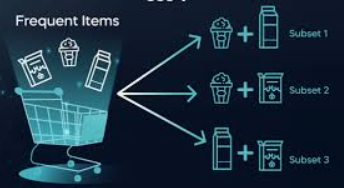


For example:
- **If by 🥛 `whole milk` then by 🥚 `eggs` with confidence 15.8%**
- **If by 🥕 `carrots` then by 🍅 `tomatoes` with confidence 12.4%**
- **If by 🍞 `bread` then by 🍓 `strawberries` with confidence 10.3%**

You will use the Apriori algorithm to achieve this goal! 🚀

## 📦 Install & Import Necessary Libraries

In [2]:
# pip install mlxtend

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx

## 📂 Load the Dataset

In [6]:
# Load dataset (assuming transactions are in a list format)
df = pd.read_csv("Groceries_dataset.csv")
df

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk
...,...,...,...
38760,4471,08-10-2014,sliced cheese
38761,2022,23-02-2014,candy
38762,1097,16-04-2014,cake bar
38763,1510,03-12-2014,fruit/vegetable juice


In [7]:
# Get the total number of unique members
unique_members_count = df['Member_number'].nunique()
print(f"Unique count of members: {unique_members_count}")

Unique count of members: 3898


# EDA

In [9]:
# Count the number of duplicated rows
duplicated_count = df.duplicated().sum()

print(f"Number of duplicated rows: {duplicated_count}")

Number of duplicated rows: 759


In [10]:
# Remove duplicated rows and keep the first occurrence
print(f"Number of rows befor removing duplicates: {df.shape[0]}")

df = df.drop_duplicates(keep='first')

print(f"Number of rows after removing duplicates: {df.shape[0]}")

Number of rows befor removing duplicates: 38765
Number of rows after removing duplicates: 38006


In [11]:
item_frequencies = df['itemDescription'].value_counts().sort_values(ascending=False)[:20]
item_frequencies

itemDescription
whole milk            2363
other vegetables      1827
rolls/buns            1646
soda                  1453
yogurt                1285
root vegetables       1041
tropical fruit        1014
bottled water          908
sausage                903
citrus fruit           795
pastry                 774
pip fruit              734
shopping bags          712
canned beer            702
bottled beer           678
whipped/sour cream     654
newspapers             582
frankfurter            565
brown bread            563
domestic eggs          555
Name: count, dtype: int64

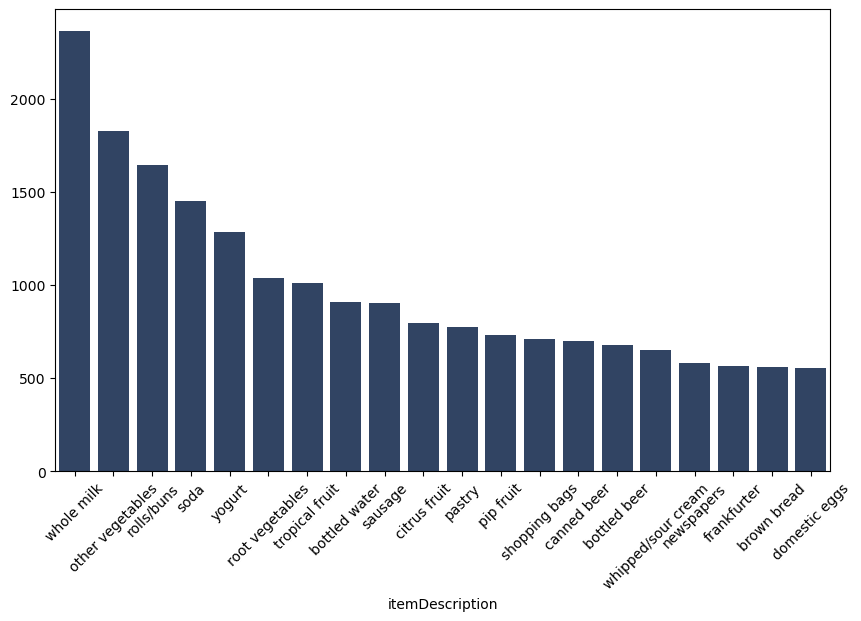

In [12]:
plt.figure(figsize=(10,6))
sns.barplot(x=item_frequencies.index, y=item_frequencies.values , color='#29426b')
plt.xticks(rotation=45)
plt.show()

# Feature Engineering

In [14]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Get the minimum and maximum dates
min_date = df['Date'].min()
max_date = df['Date'].max()

print(f"Minimum Date: {min_date}")
print(f"Maximum Date: {max_date}")

Minimum Date: 2014-01-01 00:00:00
Maximum Date: 2015-12-30 00:00:00


In [15]:
# Convert 'Date' data type
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Add 'year', 'month', and 'day' columns
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['day_name'] = df['Date'].dt.day_name()
df

,Member_number,Date,itemDescription,year,month,day,day_name
0,1808,2015-07-21,tropical fruit,2015,7,21,Tuesday
1,2552,2015-01-05,whole milk,2015,1,5,Monday
2,2300,2015-09-19,pip fruit,2015,9,19,Saturday
3,1187,2015-12-12,other vegetables,2015,12,12,Saturday
4,3037,2015-02-01,whole milk,2015,2,1,Sunday
...,...,...,...,...,...,...,...
38760,4471,2014-10-08,sliced cheese,2014,10,8,Wednesday
38761,2022,2014-02-23,candy,2014,2,23,Sunday
38762,1097,2014-04-16,cake bar,2014,4,16,Wednesday
38763,1510,2014-12-03,fruit/vegetable juice,2014,12,3,Wednesday


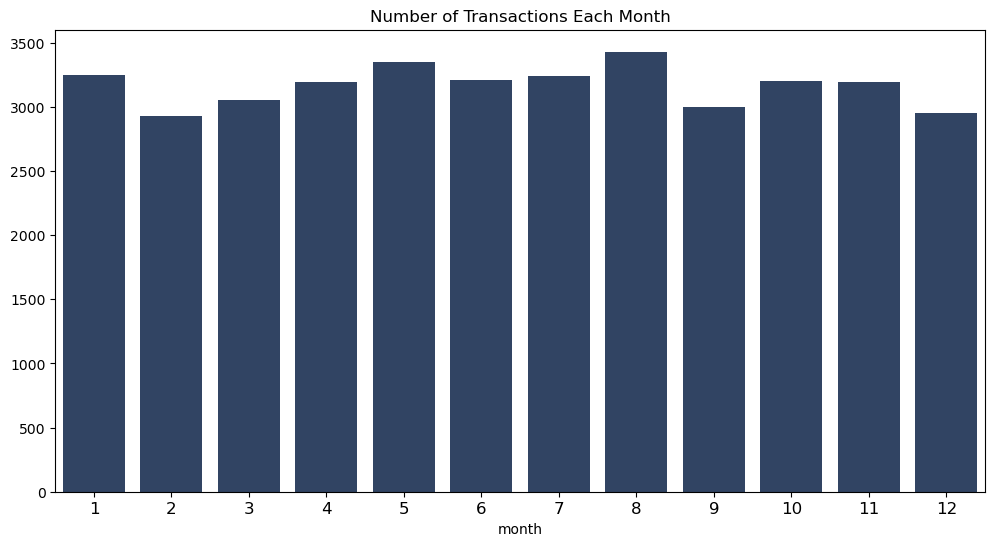

In [16]:
# Number of transactions each month
plt.figure(figsize=(12,6))

sns.barplot(x = df['month'].value_counts().index, y = df['month'].value_counts().values, color='#29426b')
plt.xticks(size=12)
plt.title('Number of Transactions Each Month')
plt.show()

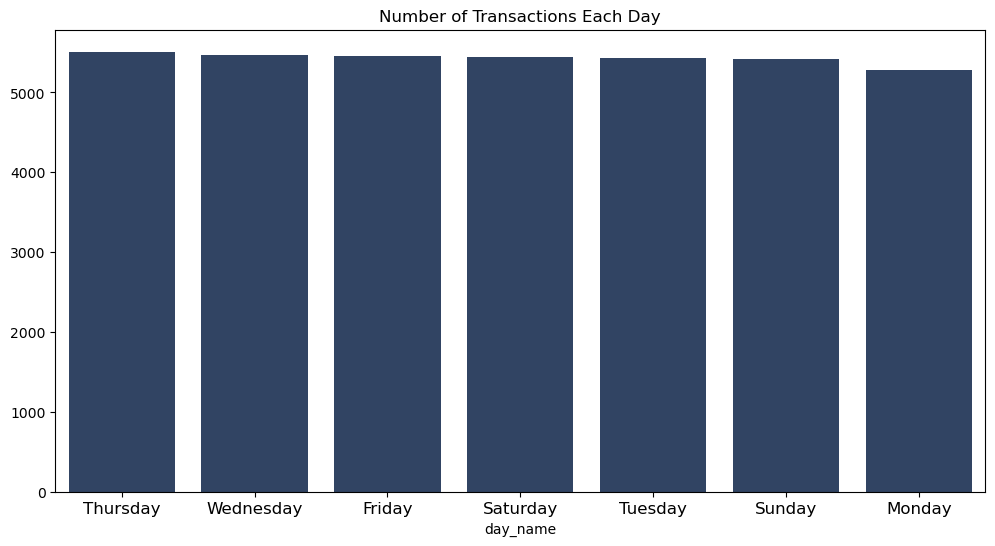

In [17]:
# Number of transactions each day
plt.figure(figsize=(12,6))

sns.barplot(x = df['day_name'].value_counts().index, y = df['day_name'].value_counts().values, color='#29426b')
plt.xticks(size=12)
plt.title('Number of Transactions Each Day')
plt.show()

# Apply Apriori Algorithm
## 📝 Preprocess the Data

تجميع البيانات: يساعد في تحديد العناصر التي يتم شراؤها بشكل متكرر معًا بواسطة الأعضاء .. يعطينا فكرة عن عدد المرات التي تم فيها شراء كل عنصر.

In [20]:
item_count = df.groupby(['Member_number', 'Date', 'itemDescription'])['itemDescription'].count().reset_index(name='Count')
item_count.head(20)

# Sort by Member_number
item_count_sorted = item_count.sort_values(by='Member_number')
item_count_sorted.head(20)

,Member_number,Date,itemDescription,Count
0,1000,2014-06-24,pastry,1
12,1000,2015-11-25,sausage,1
11,1000,2015-11-25,hygiene articles,1
10,1000,2015-07-24,misc. beverages,1
8,1000,2015-05-27,soda,1
7,1000,2015-05-27,pickled vegetables,1
9,1000,2015-07-24,canned beer,1
5,1000,2015-03-15,whole milk,1
4,1000,2015-03-15,semi-finished bread,1
3,1000,2015-03-15,sausage,1


 يسهل تعقب المعاملات لكل عضو على حدة/تتبع السلوك

In [22]:
item_count['Transaction'] = item_count.groupby(['Member_number', 'Date'])['Date'].ngroup()+1
item_count.head(20) # رقم تسلسلي

,Member_number,Date,itemDescription,Count,Transaction
0,1000,2014-06-24,pastry,1,1
1,1000,2014-06-24,salty snack,1,1
2,1000,2014-06-24,whole milk,1,1
3,1000,2015-03-15,sausage,1,2
4,1000,2015-03-15,semi-finished bread,1,2
5,1000,2015-03-15,whole milk,1,2
6,1000,2015-03-15,yogurt,1,2
7,1000,2015-05-27,pickled vegetables,1,3
8,1000,2015-05-27,soda,1,3
9,1000,2015-07-24,canned beer,1,4


In [23]:
item_count.tail(5)

,Member_number,Date,itemDescription,Count,Transaction
38001,5000,2014-11-16,bottled beer,1,14962
38002,5000,2014-11-16,other vegetables,1,14962
38003,5000,2015-02-10,root vegetables,1,14963
38004,5000,2015-02-10,semi-finished bread,1,14963
38005,5000,2015-02-10,soda,1,14963


In [24]:
item_count_pivot = item_count.pivot_table(index='Transaction', columns='itemDescription', values='Count', aggfunc='sum').fillna(0)
item_count_pivot = item_count_pivot.astype('int32')
item_count_pivot

itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
Transaction,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14959,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
14960,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14961,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Apply Algorithm

In [26]:
from mlxtend.frequent_patterns import association_rules, apriori
basket = item_count.groupby('Transaction')['itemDescription'].apply(list).reset_index()
basket

,Transaction,itemDescription
0,1,"[pastry, salty snack, whole milk]"
1,2,"[sausage, semi-finished bread, whole milk, yog..."
2,3,"[pickled vegetables, soda]"
3,4,"[canned beer, misc. beverages]"
4,5,"[hygiene articles, sausage]"
...,...,...
14958,14959,"[butter milk, whipped/sour cream]"
14959,14960,"[bottled water, herbs]"
14960,14961,"[fruit/vegetable juice, onions]"
14961,14962,"[bottled beer, other vegetables]"


## Find Frequent Itemsets

In [28]:
frequent_itemsets = apriori(item_count_pivot, min_support=0.01, use_colnames=True)
frequent_itemsets.sort_values('support', ascending=False).head(10)  # كم سلة بتحتوي هاد العنصر - نسبة شراؤه وتكراره

C:\Users\HP\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
62,0.157923,(whole milk)
40,0.122101,(other vegetables)
46,0.110005,(rolls/buns)
52,0.097106,(soda)
63,0.085879,(yogurt)
47,0.069572,(root vegetables)
57,0.067767,(tropical fruit)
5,0.060683,(bottled water)
49,0.060349,(sausage)
15,0.053131,(citrus fruit)


## Generate Association Rules

In [30]:
# Generate association rules from the frequent itemsets
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=0.5)
top_rules = rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values('confidence', ascending=False).head(10)
top_rules

,antecedents,consequents,support,confidence,lift
9,(yogurt),(whole milk),0.011161,0.129961,0.822940
4,(rolls/buns),(whole milk),0.013968,0.126974,0.804028
2,(other vegetables),(whole milk),0.014837,0.121511,0.769430
6,(soda),(whole milk),0.011629,0.119752,0.758296
0,(rolls/buns),(other vegetables),0.010559,0.095990,0.786154
3,(whole milk),(other vegetables),0.014837,0.093948,0.769430
5,(whole milk),(rolls/buns),0.013968,0.088447,0.804028
1,(other vegetables),(rolls/buns),0.010559,0.086481,0.786154
7,(whole milk),(soda),0.011629,0.073635,0.758296
8,(whole milk),(yogurt),0.011161,0.070673,0.822940


### Explain
- **Antecedent**: The "if" part of the rule. Example: "yogurt."
- **Consequent**: The "then" part of the rule, which indicates items that are likely to be purchased along with the antecedent. Example: "whole milk."
- **Support**: Measures how frequently a combination of items (antecedent and consequent) appears in the dataset. Indicates how common the itemset is.
- **Confidence**: Shows the likelihood of the consequent item being purchased when the antecedent is already in the basket. Indicates the reliability of the rule.
- **Lift**: Measures how much more likely the items are to be purchased together compared to being purchased independently. Lift > 1 indicates a positive relationship; Lift < 1 indicates a negative or insignificant relationship.

In [32]:
top_rules['antecedents'] = top_rules['antecedents'].apply(lambda x: ', '.join(list(x)))
top_rules['consequents'] = top_rules['consequents'].apply(lambda x: ', '.join(list(x)))

formatted_rules = top_rules.apply(lambda row: f"If by {row['antecedents']} then by {row['consequents']} with confidence {row['confidence']*100:.2f}%", axis=1)

for rule in formatted_rules:
    print(rule)

If by yogurt then by whole milk with confidence 13.00%
If by rolls/buns then by whole milk with confidence 12.70%
If by other vegetables then by whole milk with confidence 12.15%
If by soda then by whole milk with confidence 11.98%
If by rolls/buns then by other vegetables with confidence 9.60%
If by whole milk then by other vegetables with confidence 9.39%
If by whole milk then by rolls/buns with confidence 8.84%
If by other vegetables then by rolls/buns with confidence 8.65%
If by whole milk then by soda with confidence 7.36%
If by whole milk then by yogurt with confidence 7.07%


## Create Network Graph of Association Rules

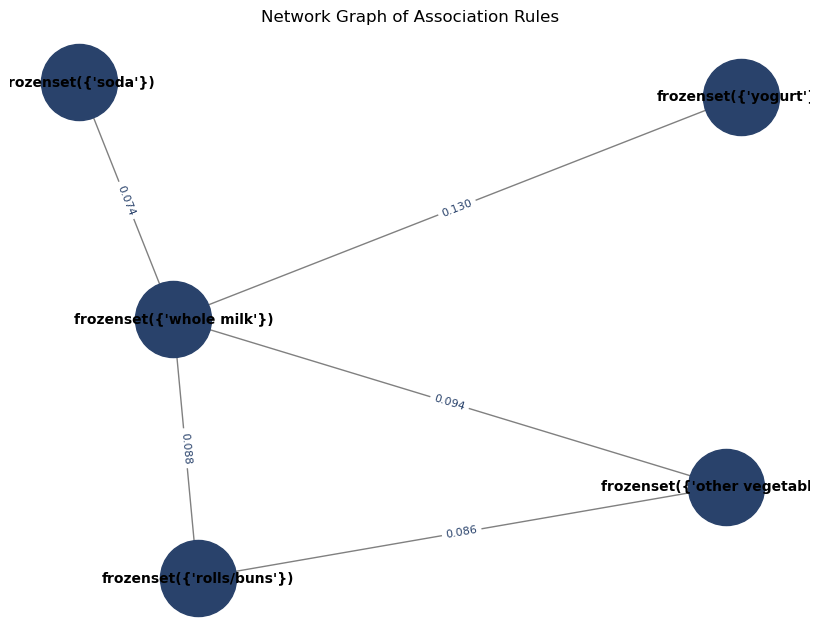

In [34]:
# graph of the association rules
G = nx.from_pandas_edgelist(rules, source='antecedents', target='consequents', edge_attr=True)

plt.figure(figsize=(8,6))
pos = nx.spring_layout(G, k=2, seed=40)

# Draw
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='#29426b', font_size=10, font_weight='bold', edge_color='gray')
edge_labels = nx.get_edge_attributes(G, 'confidence')
edge_labels = {k: f'{v:.3f}' for k, v in edge_labels.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='#29426b', font_size=8)

plt.title('Network Graph of Association Rules')
plt.show()

## Make Recommendation on Items

In [36]:
def recommend_items(items, confidence_threshold=0.1, lift_threshold=0.5):
    """  
        items (str or list): Item(s) to base the recommendation on.
        confidence_threshold (float): Minimum confidence level for the rules.
        lift_threshold (float): Minimum lift value for the rules.
    """
    
    # single item
    if isinstance(items, str):
        # Select the rules that contain the input item as the antecedent
        recommendations = rules.loc[
            (rules['antecedents'] == {items}) & 
            (rules['confidence'] > confidence_threshold) & 
            (rules['lift'] > lift_threshold)
        ]
    # list of items
    elif isinstance(items, list):
        # Select the rules that contain any of the input items as the antecedent
        recommendations = rules.loc[
            (rules['antecedents'].apply(lambda x: any(item in x for item in items))) & 
            (rules['confidence'] > confidence_threshold) & 
            (rules['lift'] > lift_threshold)
        ]
    else:
        return []

  # Print the recommendations DataFrame
    print("1. Recommendations DataFrame:")
    print(recommendations)
    
    # Extract the consequents of the selected rules as the recommended items
    recommended_items = recommendations['consequents'].apply(lambda x: list(x)).tolist()
    print("*******************************")
    print("2. Consequents as Lists:")
    print(recommended_items)

    # Flatten the list of recommended items and remove the input items from the recommendations
    recommended_items = [item for sublist in recommended_items for item in sublist if item not in items]
    print("*******************************")
    print("3. Flattened and Filtered Recommended Items:")
    print(recommended_items)
    
    # unique recommended items
    return list(set(recommended_items))

In [37]:
# recommend items for single i/p item
recommend_items("yogurt")

1. Recommendations DataFrame:
  antecedents   consequents  antecedent support  consequent support   support  \
9    (yogurt)  (whole milk)            0.085879            0.157923  0.011161   

   confidence     lift  representativity  leverage  conviction  zhangs_metric  \
9    0.129961  0.82294               1.0 -0.002401    0.967861      -0.190525   

    jaccard  certainty  kulczynski  
9  0.047975  -0.033206    0.100317  
*******************************
2. Consequents as Lists:
[['whole milk']]
*******************************
3. Flattened and Filtered Recommended Items:
['whole milk']


['whole milk']

In [38]:
# recommend items for single i/p item
recommend_items("whole milk")

1. Recommendations DataFrame:
Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, representativity, leverage, conviction, zhangs_metric, jaccard, certainty, kulczynski]
Index: []
*******************************
2. Consequents as Lists:
[]
*******************************
3. Flattened and Filtered Recommended Items:
[]


[]

In [39]:
# recommend items for multiple i/p items
recommend_items(["rolls/buns", "yogurt"])

1. Recommendations DataFrame:
    antecedents   consequents  antecedent support  consequent support  \
4  (rolls/buns)  (whole milk)            0.110005            0.157923   
9      (yogurt)  (whole milk)            0.085879            0.157923   

    support  confidence      lift  representativity  leverage  conviction  \
4  0.013968    0.126974  0.804028               1.0 -0.003404    0.964550   
9  0.011161    0.129961  0.822940               1.0 -0.002401    0.967861   

   zhangs_metric   jaccard  certainty  kulczynski  
4      -0.214986  0.055000  -0.036752    0.107711  
9      -0.190525  0.047975  -0.033206    0.100317  
*******************************
2. Consequents as Lists:
[['whole milk'], ['whole milk']]
*******************************
3. Flattened and Filtered Recommended Items:
['whole milk', 'whole milk']


['whole milk']

In [40]:
# recommend items for multiple i/p items
recommend_items(["rolls/buns", "other vegetables"])

1. Recommendations DataFrame:
          antecedents   consequents  antecedent support  consequent support  \
2  (other vegetables)  (whole milk)            0.122101            0.157923   
4        (rolls/buns)  (whole milk)            0.110005            0.157923   

    support  confidence      lift  representativity  leverage  conviction  \
2  0.014837    0.121511  0.769430               1.0 -0.004446    0.958551   
4  0.013968    0.126974  0.804028               1.0 -0.003404    0.964550   

   zhangs_metric   jaccard  certainty  kulczynski  
2      -0.254477  0.055948  -0.043241    0.107730  
4      -0.214986  0.055000  -0.036752    0.107711  
*******************************
2. Consequents as Lists:
[['whole milk'], ['whole milk']]
*******************************
3. Flattened and Filtered Recommended Items:
['whole milk', 'whole milk']


['whole milk']